# **CPE Prediction using Machine Learning**
This study aims to predict 'CPE or not' by developing a machine learning model for the isolation of patients who are suspected of infection.




## 1. Data Upload and Preprocessing

### 1-1 Requirements

In [1]:
# Install necessary libraries
!pip install imbalanced-learn
!pip install xgboost
!pip install catboost
!pip install lightgbm
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 5.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [2]:
# Import necessary libraries
import io
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [3]:
# Set random seed for reproducibility
seed = 42
np.random.seed(seed)

### 1-2 Upload Data
We will upload the training and validation datasets.


In [4]:
# Upload training data
uploaded = files.upload()

Saving CPE_training_dataset_2022.xlsx to CPE_training_dataset_2022.xlsx


In [5]:
training_data = pd.read_excel(io.BytesIO(uploaded['CPE_training_dataset_2022.xlsx']))

In [6]:
# Display the first few rows of the training dataset
training_data.head()

,CPE,sex,age,ICU_adm_day,Adm_via,Pre_adm,Under_dz,DM,CKD,ESRD_HD,...,P_Abx,FQ_3Mo,Cepha_3Mo,Carb_3Mo,BLI_3Mo,AG_3Mo,LTCF,VRE,MDRO,GI_scope
0,0,0,79,2,2,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,64,1,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,89,8,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,66,6,1,1,1,0,0,0,...,1,1,0,0,1,0,0,0,0,0
4,0,1,77,2,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Upload validation data
uploaded = files.upload()

Saving CPE_validation_dataset_2023.xlsx to CPE_validation_dataset_2023.xlsx


In [8]:
validation_data = pd.read_excel(io.BytesIO(uploaded['CPE_validation_dataset_2023.xlsx']))

In [9]:
# Display the first few rows of the validation dataset
validation_data.head()

,CPE,sex,age,ICU_adm_day,Adm_via,Pre_adm,Under_dz,DM,CKD,ESRD_HD,...,P_Abx,FQ_3Mo,Cepha_3Mo,Carb_3Mo,BLI_3Mo,AG_3Mo,LTCF,VRE,MDRO,GI_scope
0,0,1,63,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,67,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,52,3,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,74,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,73,5,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1-3 Data Preprocessing
We will preprocess the data by handling missing values and converting categorical variables into dummy/indicator variables.


In [10]:
# Define a preprocessing function
def preprocess_data(data):
    # Drop rows with missing values
    data = data.dropna()
    # Convert categorical variables into dummy/indicator variables
    data = pd.get_dummies(data, drop_first=True)
    return data

In [11]:
# Preprocess the training and validation datasets
training_data = preprocess_data(training_data)
validation_data = preprocess_data(validation_data)

### 1-4 Split Data into Training, Validation, and Test Sets
We will split the derivation set (2022 Training dataset) into training, validation, and test sets (70% training, 15% validation, 15% test).

In [12]:
# Split the training data
X = training_data.drop('CPE', axis=1)
y = training_data['CPE']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### 1-5 Data Scaling
We will scale the features to ensure that they are on a similar scale, which is important for many machine learning algorithms.

In [13]:
# Initialize the scaler
scaler = StandardScaler()

# Scale the training, validation, and test sets
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Scale the validation dataset (2023)
X_validation_data = scaler.transform(validation_data.drop('CPE', axis=1))
y_validation_data = validation_data['CPE']

## 2. Model Development



### 2-1. Logistic Regression with original dataset
We will train a Logistic Regression model on the original dataset and evaluate its performance.

In [14]:
# Train and evaluate Logistic Regression model without SMOTE
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

logistic_pred_val = logistic_model.predict(X_val)
logistic_pred_val_prob = logistic_model.predict_proba(X_val)[:, 1]

In [15]:
print("Logistic Regression - Derivation Set (2022 Training set) (Without SMOTE)")
print(confusion_matrix(y_val, logistic_pred_val))
print(classification_report(y_val, logistic_pred_val))
roc_auc_val = roc_auc_score(y_val, logistic_pred_val_prob)
precision_val, recall_val, _ = precision_recall_curve(y_val, logistic_pred_val_prob)
prc_auc_val = auc(recall_val, precision_val)
print(f"ROC AUC: {roc_auc_val:.4f}")
print(f"PRC AUC: {prc_auc_val:.4f}\n")

Logistic Regression - Derivation Set (2022 Training set) (Without SMOTE)
[[259   9]
 [ 28   3]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       268
           1       0.25      0.10      0.14        31

    accuracy                           0.88       299
   macro avg       0.58      0.53      0.54       299
weighted avg       0.83      0.88      0.85       299

ROC AUC: 0.7085
PRC AUC: 0.2291



In [16]:
logistic_pred_val_data = logistic_model.predict(X_validation_data)
logistic_pred_val_data_prob = logistic_model.predict_proba(X_validation_data)[:, 1]

print("Logistic Regression - 2023 Validation dataset (Without SMOTE)")
print(confusion_matrix(y_validation_data, logistic_pred_val_data))
print(classification_report(y_validation_data, logistic_pred_val_data))
roc_auc_val_data = roc_auc_score(y_validation_data, logistic_pred_val_data_prob)
precision_val_data, recall_val_data, _ = precision_recall_curve(y_validation_data, logistic_pred_val_data_prob)
prc_auc_val_data = auc(recall_val_data, precision_val_data)
print(f"ROC AUC: {roc_auc_val_data:.4f}")
print(f"PRC AUC: {prc_auc_val_data:.4f}\n")

Logistic Regression - 2023 Validation dataset (Without SMOTE)
[[2612   78]
 [ 188   45]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2690
           1       0.37      0.19      0.25       233

    accuracy                           0.91      2923
   macro avg       0.65      0.58      0.60      2923
weighted avg       0.89      0.91      0.90      2923

ROC AUC: 0.7516
PRC AUC: 0.2532



### 2-2. Data Augmentation with SMOTE
We will apply SMOTE to the training dataset to handle class imbalance and then train a Logistic Regression model on the augmented dataset.


In [17]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

### 2-3. Logistic Regression with Augmented Dataset by SMOTE

We will train a Logistic Regression model on the dataset augmented by SMOTE (Synthetic Minority Over-sampling Technique) to handle class imbalance and evaluate its performance.


In [18]:
# Train and evaluate Logistic Regression model with SMOTE
logistic_model_smote = LogisticRegression(max_iter=1000)
logistic_model_smote.fit(X_train_smote, y_train_smote)

logistic_pred_val_smote = logistic_model_smote.predict(X_val)
logistic_pred_val_smote_prob = logistic_model_smote.predict_proba(X_val)[:, 1]

In [19]:
print("Logistic Regression - Derivation Set (2022 Training set) (With SMOTE)")
print(confusion_matrix(y_val, logistic_pred_val_smote))
print(classification_report(y_val, logistic_pred_val_smote))
roc_auc_val_smote = roc_auc_score(y_val, logistic_pred_val_smote_prob)
precision_val_smote, recall_val_smote, _ = precision_recall_curve(y_val, logistic_pred_val_smote_prob)
prc_auc_val_smote = auc(recall_val_smote, precision_val_smote)
print(f"ROC AUC: {roc_auc_val_smote:.4f}")
print(f"PRC AUC: {prc_auc_val_smote:.4f}\n")

Logistic Regression - Derivation Set (2022 Training set) (With SMOTE)
[[199  69]
 [ 16  15]]
              precision    recall  f1-score   support

           0       0.93      0.74      0.82       268
           1       0.18      0.48      0.26        31

    accuracy                           0.72       299
   macro avg       0.55      0.61      0.54       299
weighted avg       0.85      0.72      0.77       299

ROC AUC: 0.6720
PRC AUC: 0.2090



In [20]:
logistic_pred_val_data_smote = logistic_model_smote.predict(X_validation_data)
logistic_pred_val_data_smote_prob = logistic_model_smote.predict_proba(X_validation_data)[:, 1]

print("Logistic Regression - 2023 Validation dataset (With SMOTE)")
print(confusion_matrix(y_validation_data, logistic_pred_val_data_smote))
print(classification_report(y_validation_data, logistic_pred_val_data_smote))
roc_auc_val_data_smote = roc_auc_score(y_validation_data, logistic_pred_val_data_smote_prob)
precision_val_data_smote, recall_val_data_smote, _ = precision_recall_curve(y_validation_data, logistic_pred_val_data_smote_prob)
prc_auc_val_data_smote = auc(recall_val_data_smote, precision_val_data_smote)
print(f"ROC AUC: {roc_auc_val_data_smote:.4f}")
print(f"PRC AUC: {prc_auc_val_data_smote:.4f}\n")

Logistic Regression - 2023 Validation dataset (With SMOTE)
[[1975  715]
 [  89  144]]
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      2690
           1       0.17      0.62      0.26       233

    accuracy                           0.72      2923
   macro avg       0.56      0.68      0.55      2923
weighted avg       0.89      0.72      0.79      2923

ROC AUC: 0.7095
PRC AUC: 0.2134




### 2-4. Training and Evaluation of Other Machine Learning Models with originial dataset
- Decision Tree
- Extra Tree
- Random Forest
- Gradient Boosting
- Ligt GBM
- CatBoost
- Ensemble

#### 2-4-1. Model Training with Original Dataset


In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [22]:
# Define machine learning models
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

In [23]:
# Train and evaluate models on original dataset
model_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)

    pred_val = model.predict(X_val)
    pred_val_prob = model.predict_proba(X_val)[:, 1]

    print(f"{name} - Derivation Set (2022 Training set) (Without SMOTE)")
    print(confusion_matrix(y_val, pred_val))
    print(classification_report(y_val, pred_val))
    roc_auc_val = roc_auc_score(y_val, pred_val_prob)
    precision_val, recall_val, _ = precision_recall_curve(y_val, pred_val_prob)
    prc_auc_val = auc(recall_val, precision_val)
    print(f"ROC AUC: {roc_auc_val:.4f}")
    print(f"PRC AUC: {prc_auc_val:.4f}\n")

    model_results[name] = model

Decision Tree - Derivation Set (2022 Training set) (Without SMOTE)
[[236  32]
 [ 23   8]]
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       268
           1       0.20      0.26      0.23        31

    accuracy                           0.82       299
   macro avg       0.56      0.57      0.56       299
weighted avg       0.84      0.82      0.83       299

ROC AUC: 0.5693
PRC AUC: 0.2675

Random Forest - Derivation Set (2022 Training set) (Without SMOTE)
[[267   1]
 [ 30   1]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       268
           1       0.50      0.03      0.06        31

    accuracy                           0.90       299
   macro avg       0.70      0.51      0.50       299
weighted avg       0.86      0.90      0.85       299

ROC AUC: 0.7415
PRC AUC: 0.2693

Gradient Boosting - Derivation Set (2022 Training set) (Without SMOTE)
[[264   4]
 [ 29   2]]
      

#### 2-4-2. Ensemble Model on Original Dataset


In [24]:
# Define and train ensemble model on original dataset
ensemble_model = VotingClassifier(estimators=[(name, model) for name, model in models.items()], voting='soft')
ensemble_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 152, number of negative: 1242
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 1394, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.109039 -> initscore=-2.100598
[LightGBM] [Info] Start training from score -2.100598


VotingClassifier(estimators=[('Decision Tree', DecisionTreeClassifier()),
                             ('Random Forest', RandomForestClassifier()),
                             ('Gradient Boosting',
                              GradientBoostingClassifier()),
                             ('Extra Trees', ExtraTreesClassifier()),
                             ('LightGBM', LGBMClassifier()),
                             ('CatBoost',
                              <catboost.core.CatBoostClassifier object at 0x78d896987790>)],
                 voting='soft')

In [25]:
pred_val_ensemble = ensemble_model.predict(X_val)
pred_val_prob_ensemble = ensemble_model.predict_proba(X_val)[:, 1]

In [26]:
print("Ensemble Model - Derivation Set (2022 Training set) (Without SMOTE)")
print(confusion_matrix(y_val, pred_val_ensemble))
print(classification_report(y_val, pred_val_ensemble))
roc_auc_val_ensemble = roc_auc_score(y_val, pred_val_prob_ensemble)
precision_val_ensemble, recall_val_ensemble, _ = precision_recall_curve(y_val, pred_val_prob_ensemble)
prc_auc_val_ensemble = auc(recall_val_ensemble, precision_val_ensemble)
print(f"ROC AUC: {roc_auc_val_ensemble:.4f}")
print(f"PRC AUC: {prc_auc_val_ensemble:.4f}\n")

model_results['Ensemble'] = ensemble_model

Ensemble Model - Derivation Set (2022 Training set) (Without SMOTE)
[[263   5]
 [ 28   3]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       268
           1       0.38      0.10      0.15        31

    accuracy                           0.89       299
   macro avg       0.64      0.54      0.55       299
weighted avg       0.85      0.89      0.86       299

ROC AUC: 0.7203
PRC AUC: 0.2963



#### 2-4-3. Model Evaluation on Validation Dataset

In [27]:
for name, model in model_results.items():
    pred_val_data = model.predict(X_validation_data)
    pred_val_data_prob = model.predict_proba(X_validation_data)[:, 1]

    print(f"{name} - 2023 Validation dataset (Without SMOTE)")
    print(confusion_matrix(y_validation_data, pred_val_data))
    print(classification_report(y_validation_data, pred_val_data))
    roc_auc_val_data = roc_auc_score(y_validation_data, pred_val_data_prob)
    precision_val_data, recall_val_data, _ = precision_recall_curve(y_validation_data, pred_val_data_prob)
    prc_auc_val_data = auc(recall_val_data, precision_val_data)
    print(f"ROC AUC: {roc_auc_val_data:.4f}")
    print(f"PRC AUC: {prc_auc_val_data:.4f}\n")


Decision Tree - 2023 Validation dataset (Without SMOTE)
[[2341  349]
 [ 162   71]]
              precision    recall  f1-score   support

           0       0.94      0.87      0.90      2690
           1       0.17      0.30      0.22       233

    accuracy                           0.83      2923
   macro avg       0.55      0.59      0.56      2923
weighted avg       0.87      0.83      0.85      2923

ROC AUC: 0.5875
PRC AUC: 0.2646

Random Forest - 2023 Validation dataset (Without SMOTE)
[[2648   42]
 [ 208   25]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2690
           1       0.37      0.11      0.17       233

    accuracy                           0.91      2923
   macro avg       0.65      0.55      0.56      2923
weighted avg       0.88      0.91      0.89      2923

ROC AUC: 0.7365
PRC AUC: 0.2283

Gradient Boosting - 2023 Validation dataset (Without SMOTE)
[[2611   79]
 [ 186   47]]
              precision    

### 2-5. Training and Evaluation of Other Machine Learning Models with Augmented Dataset by SMOTE

In [28]:
# Model Training and Performance Evaluation (With SMOTE)
model_results_smote = {}

for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)

    pred_val_smote = model.predict(X_val)
    pred_val_smote_prob = model.predict_proba(X_val)[:, 1]

    print(f"{name} - Derivation Set (2022 Training set) (With SMOTE)")
    print(confusion_matrix(y_val, pred_val_smote))
    print(classification_report(y_val, pred_val_smote))
    roc_auc_val_smote = roc_auc_score(y_val, pred_val_smote_prob)
    precision_val_smote, recall_val_smote, _ = precision_recall_curve(y_val, pred_val_smote_prob)
    prc_auc_val_smote = auc(recall_val_smote, precision_val_smote)
    print(f"ROC AUC: {roc_auc_val_smote:.4f}")
    print(f"PRC AUC: {prc_auc_val_smote:.4f}\n")

    model_results_smote[name] = model

# Define and Train Ensemble Model (With SMOTE)
ensemble_model_smote = VotingClassifier(estimators=[(name, model) for name, model in models.items()], voting='soft')
ensemble_model_smote.fit(X_train_smote, y_train_smote)

pred_val_ensemble_smote = ensemble_model_smote.predict(X_val)
pred_val_prob_ensemble_smote = ensemble_model_smote.predict_proba(X_val)[:, 1]

print("Ensemble Model - Derivation Set (2022 Training set) (With SMOTE)")
print(confusion_matrix(y_val, pred_val_ensemble_smote))
print(classification_report(y_val, pred_val_ensemble_smote))
roc_auc_val_ensemble_smote = roc_auc_score(y_val, pred_val_prob_ensemble_smote)
precision_val_ensemble_smote, recall_val_ensemble_smote, _ = precision_recall_curve(y_val, pred_val_prob_ensemble_smote)
prc_auc_val_ensemble_smote = auc(recall_val_ensemble_smote, precision_val_ensemble_smote)
print(f"ROC AUC: {roc_auc_val_ensemble_smote:.4f}")
print(f"PRC AUC: {prc_auc_val_ensemble_smote:.4f}\n")

model_results_smote['Ensemble'] = ensemble_model_smote


Decision Tree - Derivation Set (2022 Training set) (With SMOTE)
[[240  28]
 [ 21  10]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       268
           1       0.26      0.32      0.29        31

    accuracy                           0.84       299
   macro avg       0.59      0.61      0.60       299
weighted avg       0.85      0.84      0.84       299

ROC AUC: 0.6091
PRC AUC: 0.3280

Random Forest - Derivation Set (2022 Training set) (With SMOTE)
[[262   6]
 [ 26   5]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       268
           1       0.45      0.16      0.24        31

    accuracy                           0.89       299
   macro avg       0.68      0.57      0.59       299
weighted avg       0.86      0.89      0.87       299

ROC AUC: 0.7398
PRC AUC: 0.2530

Gradient Boosting - Derivation Set (2022 Training set) (With SMOTE)
[[257  11]
 [ 24   7]]
              p

In [29]:
# Evaluate Models on 2023 Validation dataset (With SMOTE)
for name, model in model_results_smote.items():
    pred_val_data_smote = model.predict(X_validation_data)
    pred_val_data_smote_prob = model.predict_proba(X_validation_data)[:, 1]

    print(f"{name} - 2023 Validation dataset (With SMOTE)")
    print(confusion_matrix(y_validation_data, pred_val_data_smote))
    print(classification_report(y_validation_data, pred_val_data_smote))
    roc_auc_val_data_smote = roc_auc_score(y_validation_data, pred_val_data_smote_prob)
    precision_val_data_smote, recall_val_data_smote, _ = precision_recall_curve(y_validation_data, pred_val_data_smote_prob)
    prc_auc_val_data_smote = auc(recall_val_data_smote, precision_val_data_smote)
    print(f"ROC AUC: {roc_auc_val_data_smote:.4f}")
    print(f"PRC AUC: {prc_auc_val_data_smote:.4f}\n")


Decision Tree - 2023 Validation dataset (With SMOTE)
[[2322  368]
 [ 164   69]]
              precision    recall  f1-score   support

           0       0.93      0.86      0.90      2690
           1       0.16      0.30      0.21       233

    accuracy                           0.82      2923
   macro avg       0.55      0.58      0.55      2923
weighted avg       0.87      0.82      0.84      2923

ROC AUC: 0.5797
PRC AUC: 0.2551

Random Forest - 2023 Validation dataset (With SMOTE)
[[2559  131]
 [ 195   38]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2690
           1       0.22      0.16      0.19       233

    accuracy                           0.89      2923
   macro avg       0.58      0.56      0.56      2923
weighted avg       0.87      0.89      0.88      2923

ROC AUC: 0.7414
PRC AUC: 0.1786

Gradient Boosting - 2023 Validation dataset (With SMOTE)
[[2541  149]
 [ 181   52]]
              precision    recall  f

## 3. Result Visualization

###3-1 ROC-AUC and PR-AUC Plots

After evaluating above models, we found that Logistic Regression performed the best. Therefore, we will plot the ROC-AUC and PR-AUC curves for our Logistic Regression models trained on both the original and augmented datasets.

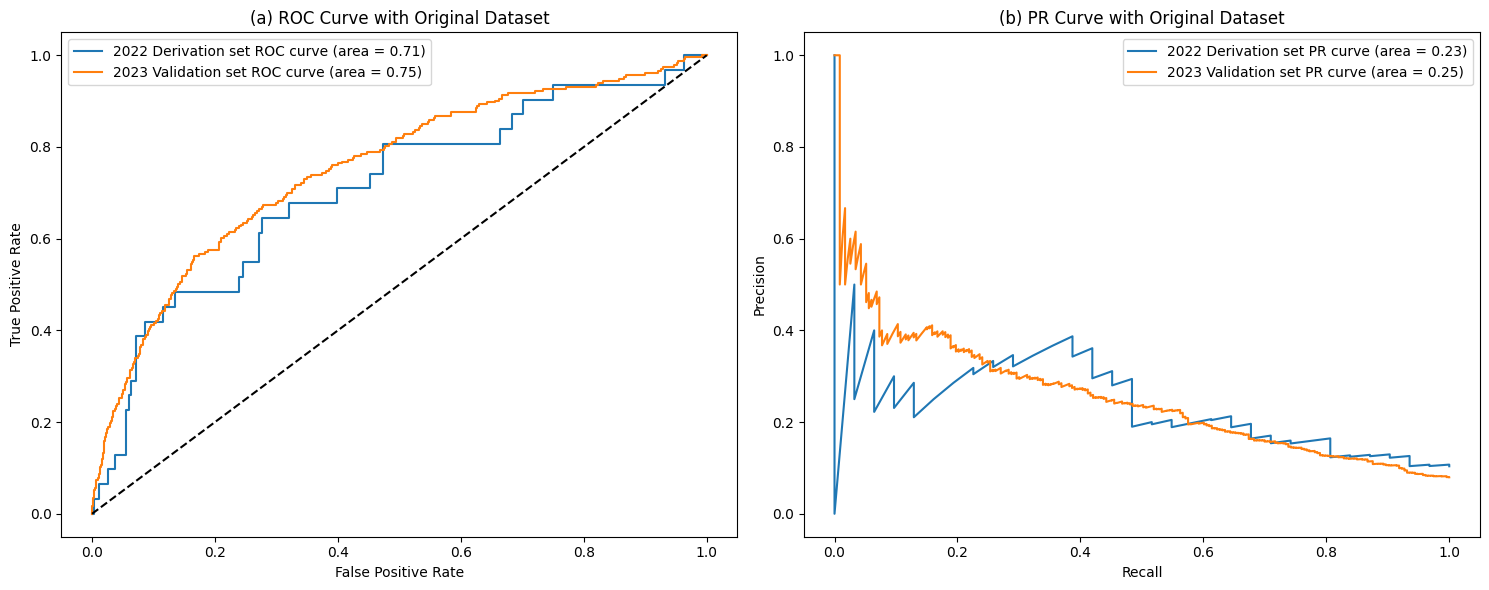

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

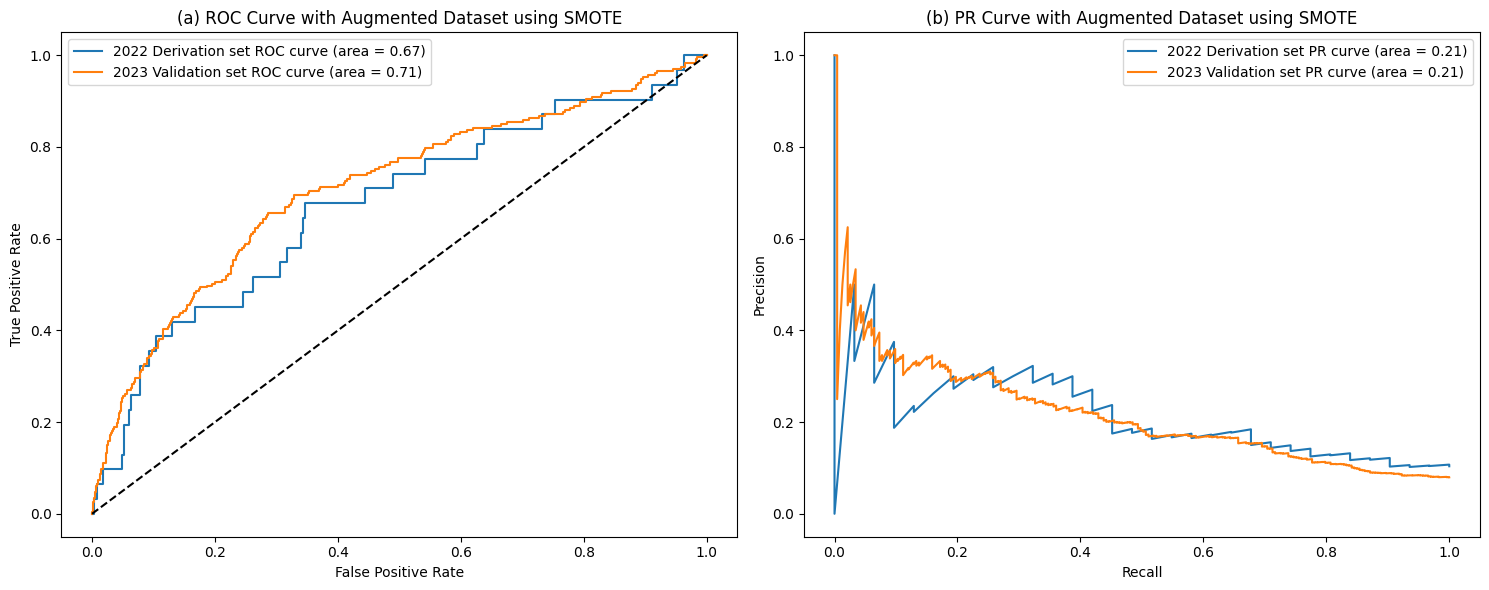

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
# Function to plot ROC and PR curves
def plot_roc_pr_curves(model_name, fpr, tpr, fpr_val, tpr_val, precision, recall, precision_val, recall_val, roc_auc, roc_auc_val, prc_auc, prc_auc_val, smote=False):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    smote_str = "(With SMOTE)" if smote else "(Without SMOTE)"
    roc_title = "ROC Curve with Augmented Dataset using SMOTE" if smote else "ROC Curve with Original Dataset"
    pr_title = "PR Curve with Augmented Dataset using SMOTE" if smote else "PR Curve with Original Dataset"

    # Plot ROC curve
    axs[0].plot(fpr, tpr, label=f'2022 Derivation set ROC curve (area = {roc_auc:.2f})')
    axs[0].plot(fpr_val, tpr_val, label=f'2023 Validation set ROC curve (area = {roc_auc_val:.2f})')
    axs[0].plot([0, 1], [0, 1], 'k--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title(f'(a) {roc_title}')
    axs[0].legend(loc='best')

    # Plot Precision-Recall curve
    axs[1].plot(recall, precision, label=f'2022 Derivation set PR curve (area = {prc_auc:.2f})')
    axs[1].plot(recall_val, precision_val, label=f'2023 Validation set PR curve (area = {prc_auc_val:.2f})')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_title(f'(b) {pr_title}')
    axs[1].legend(loc='best')

    plt.tight_layout()
    plt.savefig(f'high_resolution_plot_{model_name}_{smote_str}.png', dpi=300)
    plt.show()

    # Colab에서 파일 다운로드
    files.download(f'high_resolution_plot_{model_name}_{smote_str}.png')

# Logistic Regression - Without SMOTE
fpr, tpr, _ = roc_curve(y_val, logistic_pred_val_prob)
fpr_val, tpr_val, _ = roc_curve(y_validation_data, logistic_pred_val_data_prob)
precision, recall, _ = precision_recall_curve(y_val, logistic_pred_val_prob)
precision_val, recall_val, _ = precision_recall_curve(y_validation_data, logistic_pred_val_data_prob)
roc_auc = roc_auc_score(y_val, logistic_pred_val_prob)
roc_auc_val = roc_auc_score(y_validation_data, logistic_pred_val_data_prob)
prc_auc = auc(recall, precision)
prc_auc_val = auc(recall_val, precision_val)
plot_roc_pr_curves('Logistic Regression', fpr, tpr, fpr_val, tpr_val, precision, recall, precision_val, recall_val, roc_auc, roc_auc_val, prc_auc, prc_auc_val, smote=False)

# Logistic Regression - With SMOTE
fpr_smote, tpr_smote, _ = roc_curve(y_val, logistic_pred_val_smote_prob)
fpr_val_smote, tpr_val_smote, _ = roc_curve(y_validation_data, logistic_pred_val_data_smote_prob)
precision_smote, recall_smote, _ = precision_recall_curve(y_val, logistic_pred_val_smote_prob)
precision_val_smote, recall_val_smote, _ = precision_recall_curve(y_validation_data, logistic_pred_val_data_smote_prob)
roc_auc_smote = roc_auc_score(y_val, logistic_pred_val_smote_prob)
roc_auc_val_smote = roc_auc_score(y_validation_data, logistic_pred_val_data_smote_prob)
prc_auc_smote = auc(recall_smote, precision_smote)
prc_auc_val_smote = auc(recall_val_smote, precision_val_smote)
plot_roc_pr_curves('Logistic Regression', fpr_smote, tpr_smote, fpr_val_smote, tpr_val_smote, precision_smote, recall_smote, precision_val_smote, recall_val_smote, roc_auc_smote, roc_auc_val_smote, prc_auc_smote, prc_auc_val_smote, smote=True)


###3-2 SHAP Value Analysis

We will use SHAP (SHapley Additive exPlanations) to analyze the feature importance in our Logistic Regression model.

/usr/local/lib/python3.10/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


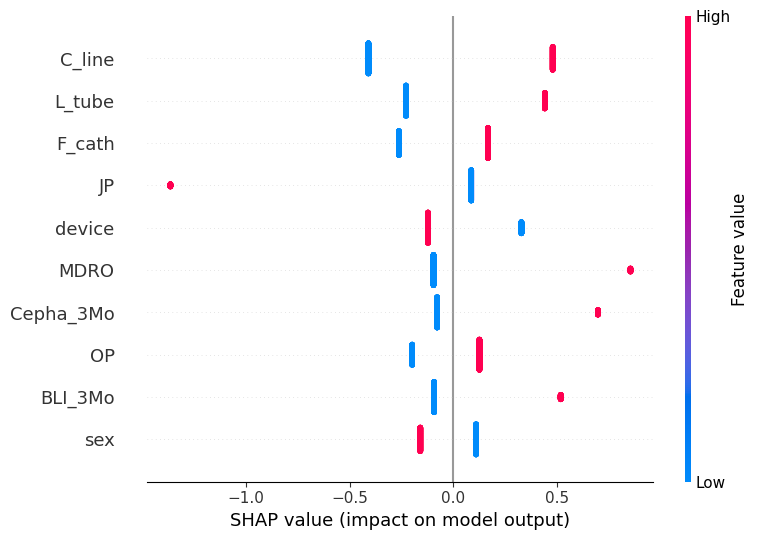

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
import shap
import matplotlib.pyplot as plt
from google.colab import files

# Logistic Regression 모델에 대한 SHAP 값 계산 및 시각화
explainer = shap.LinearExplainer(logistic_model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_train)

# Top 10 Features
shap.summary_plot(shap_values, X_train, feature_names=X.columns, max_display=10)

# 고해상도로 화질 변환하여 저장
plt.figure()
shap.summary_plot(shap_values, X_train, feature_names=X.columns, max_display=10, show=False)
plt.savefig('SHAP_Summary_Plot_High_Resolution.png', dpi=300, bbox_inches='tight')
files.download('SHAP_Summary_Plot_High_Resolution.png')
plt.close()